# <center><b>Метод преноса стила описан у раду <br/> <i>P²-GAN: Efficient Style Transfer Using Single Style Image (Zheng & Liu, 2020)</i></b></center>

P²-GAN (Patch Permutation Generative Adversarial Network) метода преноса стила, као што јој само име сугерише, заснована је на генеративној супарничкој мрежи која захваљујући техници пермутације парчића (енг. *patch permutation*) може ефикасно да научи модел стила на основу само једне улазне слике. Наиме, претходне методе преноса стила засноване на генеративним супарничким мрежама (на пример, MGAN из рада Li & Wand, 2016) захтевале су да се тренинг врши над сликама које су већ стилизоване (неком другом методом), што је драстично успоравало процес тренирања модела за нову слику стила. P²-GAN овај проблем превазилази специфичном архитектуром мреже: ова мрежа сачињена је од четири компоненте, а то су пермутатор парчића, генератор, дискириминатор парчића и VGG16 конволутивна неуронска мрежа (Simonyan & Zisserman, 2015) предтренирана на [*ImageNet*](https://www.image-net.org/) скупу података.

![p2gan](images/figures/p2gan.png)

Генерално, тренирање метода преноса стила заснованих на генеративним супарничким мрежама састоји се од истовременог тренирања генератора $G(\cdot)$ и дискриминатора $D(\cdot)$ на скупу слика садржаја $\mathcal{X} = \big\{c_i\big\}^N_{i=1}$ и скупу слика стила $\mathcal{Y} = \big\{s_i\big\}^M_{i=1}$. Тада за нову слику садржаја $c_*$, $G(c_*)$ ће задржати садржај слике $c_*$, а узети стил скупа $\mathcal{Y}$. Када је $M = 1$ традиционални методи тренирања генеративних супарничких мрежа не могу да функционишу јер само један узорак не представља дистрибуцију. Овај проблем у P²-GAN мрежи решен је имплементацијом пермутатора парчића.

**Пермутатор парчића**

Пошто је идеја да се користи само једна улазна слика стила, мора се некако на основу ње направити тренинг скуп од $K$ слика. Тај посао обавља пермутатор парчића. Наиме на основу слике стила $s$ величине $W_s \times H_s$ узимају се парчићи величине $n \times n$ тако да за било који парчић $p_j$ важи $p_j(u, v) = s[(W_s - n)r + u, (H_s - n)r +v]$, где је $r$ насумична променљива са униформном расподелом на интервалу $[0,1]$. После $T^2$ насумичних исецања парчића, добија се $p_j, j = 1, ..., T^2$ парчића који се распоређују у блок матрицу $\psi(s)$ на следећи начин:

$$
\psi(s) = \begin{bmatrix} 
            p_1 & p_2 & \dots & p_T \\
            p_{T+1} & p_{T+2} & \dots & p_{2T} \\
            \vdots & \vdots & \ddots & \vdots \\
            p_{(T-1)T + 1} & p_{(T-1)T + 2} & \dots & p_{T^2}
          \end{bmatrix}
$$

Таква $\psi(s)$ матрица представља $nT \times nT$ пермутацију оргиналне слике стила $s$. Понављајући описани процес $K$ пута, добија се тренинг скуп $\mathcal{Y}_\psi = \big\{\psi_i(s)\big\}^K_{i=1}$ тражене дужине $K$ на основу само једне улазне слике стила $s$.

**Дискриминатор парчића**

Претходно описана операција пермутације парчића очигледно креира неповезане слике са прекидима у текстури на прелазима са једног на суседни парчић. Та чињеница онемогућава коришћење традиционалних дискриминатора због артифаката које би то изазвало на резултућој слици. Из тог разлога, користи се трослојна конволутивна неуронска мрежа са специјалном везом између корака конволуције (енг. *stride*) и осталих параметара мреже. Наиме, ако су парчићи величине $n \times n$, а филтер конволутивног слоја $l$ величине $k_l \times k_l$, а корак $s_l$, онда мора да важи:

$$
\begin{cases}
k_l = s_l \\
n = \prod^3_{l=1} k_l
\end{cases}
$$

Ово правило обезбеђује да се сва конволутивна израчунавања увек одвијају у оквиру једног парчића, и да се приликом померања филтера никада неће прећи у суседни парчић, што омогућава мрежи да у напред пропагира непрекидне текстуре, иако постоје прекиди у улазној слици. Идеја овог правила може се видети на следећој слици:

![stride](images/figures/stride.png)

Коначно, дискриминатор парчића $D_p$ има следећу архитектуру за на пример $n = 9$:

|Конволутивни слој|Величина филтера|Корак|Активација|
|---|---|---|---|
|1|3×3×3×256|3|LeakyReLU|
|2|3×3×256×512|3|LeakyReLU|
|3|1×1×512×1|1|Sigmoid|
||Слој агрегације упросечавањем||

**Генератор**

Генератор $G$ има енкодер-декодер архитектуру са по три слоја у енкодеру и декодеру и једним резидуалним слојем. Између унутрашња два пара слојева енкодера и декодера постоје директне везе (енг. *skip connections*). На наредној слици може се видети шема архитектуре генератора:

![generator](images/figures/generator.png)

Енкодер слој има следећу архитектуру:
1. Слој конволуције по дубини (енг. *depthwise convolution*)
2. Слој стандардизације на инстанци (енг. *instance normalization*)
3. ReLU слој
4. Слој конволуције
5. Слој стандардизације на инстанци
6. ReLU слој

Резидуални слој има исту архитектуру као енкодер слој, једино има другачију величину филтера и корак.

Декодер слој има следећу архитектуру:
1. Слој за увећавање методом најближег суседа (енг. *nearest-neighbor upsampling*)
2. Слој конволуције по дубини
3. Слој стандардизације на инстанци
4. Слој конволуције
5. Слој стандардизације на инстанци
6. ReLU слој

Додатно, приликом тренирања генератора, користи се излаз из `conv1_1` слоја VGG16 мреже предтрениране на ImageNet скупу података да би се сачувале информације о структури слике садржаја.

**Функција циља**

За поменути генератор $G$, дискриминатор парчића $D_p$ и слику стила $y$, функција циља чијом оптимизацијом се врши тренирање P²-GAN мреже је следећа:

$$
\min_G\max_{D_p}\mathcal{L}(G,D_p) = \mathcal{L}_{adv}(G,D_p) + \lambda\mathcal{L}_{content}(G)
$$

при чему је:

- $\mathcal{L}_{adv}(G,D_p)$ супарничка грешка (енг. *adversarial loss*) дата са $\mathcal{L}_{adv}(G,D_p) = \mathbb{E}_{y \in \mathcal{Y}_\psi}\big[\log{D_p(y)}\big] + \mathbb{E}_{x \in \mathcal{X}}\big[\log{(1 - D_p(G(x)))}\big]$
- $\mathcal{L}_{content}(G)$ грешка садржаја дата са $\mathcal{L}_{content}(G) = \frac{1}{CHW} \mathbb{E}_{x \in \mathcal{X}}||\phi(x) - \phi(G(x))||^2_2$, где $\phi(\cdot)$ представља излаз из `conv1_1` слоја VGG16 мреже, а $C$, $H$ и $W$ редом број филтера, висину и ширину тог слоја
- $\lambda$ параметар баланса између супарничке грешке и грешке садржаја

Решавањем овог оптимизационог проблема, за произвољну слику $x_*$, излазна слика $G(x_*)$  имаће стил слике $y$, а задржаће информације о својој структури садржаја.

**Тренирање P²-GAN мреже**

За тренирање P²-GAN мреже користи се [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) скуп података. Како код ове методе нема валидације и тестирања, користе се сва три скупа слика (тренинг, валидација и тест) што даје скуп од близу десет хиљада слика.  На следећој слици може се видети неколико насумично одабраних слика из овог скупа. 

![pascalvocsample](images/figures/pascalvocsample.jpg)

У пракси, две до три епохе тренирања дају задовољавајуће резултате. На модерним графичким картама једна епоха траје око 5 минута.

Сада следи кратка демонстрација рада ове методе. Претпоставља се да је поменути скуп података скинут и отпакован у директоријум заједно са овом Jupyter свеском.

In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os import listdir

Имајући у виду да је претходно детаљно описана архитектура генератора и дискриминатора, ради боље читљивости кода, њихови модели неће бити овде дефинисани, већ ће бити увезени из датотеке `p2gan_models.py` која се налази заједно са овом Jupyter свеском у директоријуму.

In [2]:
from p2gan_models import Generator, Discriminator, Vgg16Partial

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET_PATH = 'VOCdevkit/VOC2007/JPEGImages/'
paths = listdir(DATASET_PATH)
BATCH_SIZE = 16
DATASET_SIZE = len(paths)
BATCHES = DATASET_SIZE // BATCH_SIZE
EPOCHS = 3

LAMBDA = 7e-3
PATCH_SIZE = 9
T = 24
C = 64
H = 216
W = 216

In [4]:
def path_permutation(image, patch_size=PATCH_SIZE, n=T):
  pp = np.zeros((n*patch_size, n*patch_size, 3), dtype=np.float32)
  im_shape = image.shape
  for i in range(n):
    for j in range(n):
      y_random = int((im_shape[0] - patch_size) * np.random.uniform())
      x_random = int((im_shape[1] - patch_size) * np.random.uniform())
      pp[i*patch_size:i*patch_size+patch_size, j*patch_size:j*patch_size+patch_size, :] = image[y_random:y_random+patch_size, x_random:x_random+patch_size, :]
  return pp

In [5]:
def prepare_content_batch(image_paths):
  transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Resize((H, W)),
                                            torchvision.transforms.ToTensor()
  ])
  first = True
  for path in image_paths:
    if first:
      image = Image.open(DATASET_PATH + path)
      batch = (transform(image).unsqueeze(0) - 0.5)*2
      first = False
    else:
      image = Image.open(DATASET_PATH + path)
      batch = torch.vstack((batch, (transform(image).unsqueeze(0)-0.5)*2))
  return batch

In [6]:
def prepare_style_batch(style_image, batch_size):
  batch = torchvision.transforms.ToTensor()(path_permutation(style_image)).unsqueeze(0)
  for i in range(1, batch_size):
    batch = torch.vstack((batch, torchvision.transforms.ToTensor()(path_permutation(style_image)).unsqueeze(0)))
  return batch

In [7]:
content_image = Image.open('images/content/tubingen.jpg').resize((343, 256))
style_image = Image.open('images/style/starry_night.jpg').resize((410, 216))
simage = (np.array(style_image) / 255.0 - 0.5) * 2
cimage = (np.array(content_image) / 255.0 - 0.5) * 2

In [8]:
gen = Generator().to(device)
disc = Discriminator(T, 3).to(device)
vgg = Vgg16Partial().to(device)

g_optimizer = torch.optim.RMSprop(gen.parameters(), lr=5e-4, alpha=0.9)
d_optimizer = torch.optim.RMSprop(disc.parameters(), lr=5e-4, alpha=0.9)
        
g_losses = []
d_losses = []

vgg_transform = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

In [9]:
for epoch in range(EPOCHS):
  np.random.shuffle(paths)
  for batch_num in range(BATCHES):    
    style_images = prepare_style_batch(simage, BATCH_SIZE).to(device)
    content_images = prepare_content_batch(paths[batch_num*BATCH_SIZE:batch_num*BATCH_SIZE+BATCH_SIZE]).to(device)
    generator_images = gen(content_images).to(device)
     
    
    d_optimizer.zero_grad()
    
    d_real_d = torch.mean(disc(style_images))
    d_fake_d = torch.mean(disc(generator_images.detach()))
    d_loss = -(torch.log(d_real_d) + torch.log(1.0 - d_fake_d))
    d_loss.backward()
    d_losses.append((d_real_d.detach().cpu() + d_fake_d.detach().cpu())/2)
    d_optimizer.step()
    
    for _ in range(2):
        g_optimizer.zero_grad()
        
        generator_images = gen(content_images).to(device)
        
        d_fake = disc(generator_images)
        mean_d_fake = torch.mean(d_fake)
        g_disc_loss = -torch.log(torch.mean((d_fake) ** (1.0 - (d_fake - mean_d_fake))))

        vgg_c = vgg(vgg_transform(content_images))
        vgg_g = vgg(vgg_transform(generator_images))
        
        g_loss = (torch.norm(vgg_c - vgg_g)**2) * LAMBDA / (BATCH_SIZE * C * H * W) + g_disc_loss
        g_loss.backward()
        g_optimizer.step()
    g_losses.append(g_loss.detach().cpu())
    
    if batch_num % 200 == 0:
        print('Epoch: {} Batch: {:4} Disc fake loss: {:.6f} Disc real loss: {:.6f} Disc total loss: {:.6f} Gen loss: {:.6f}'.format(epoch + 1, batch_num, d_fake_d.detach().cpu(), d_real_d.detach().cpu(), d_loss.detach().cpu(), g_loss.detach().cpu()))

Epoch: 1 Batch:    0 Disc fake loss: 0.495068 Disc real loss: 0.501495 Disc total loss: 1.373494 Gen loss: 0.794685
Epoch: 1 Batch:  200 Disc fake loss: 0.482461 Disc real loss: 0.492274 Disc total loss: 1.367390 Gen loss: 0.715619
Epoch: 1 Batch:  400 Disc fake loss: 0.489367 Disc real loss: 0.511687 Disc total loss: 1.342146 Gen loss: 0.729724
Epoch: 1 Batch:  600 Disc fake loss: 0.498813 Disc real loss: 0.514887 Disc total loss: 1.354584 Gen loss: 0.767002
Epoch: 2 Batch:    0 Disc fake loss: 0.480161 Disc real loss: 0.490257 Disc total loss: 1.367061 Gen loss: 0.735309
Epoch: 2 Batch:  200 Disc fake loss: 0.488840 Disc real loss: 0.511453 Disc total loss: 1.341573 Gen loss: 0.740618
Epoch: 2 Batch:  400 Disc fake loss: 0.472742 Disc real loss: 0.489504 Disc total loss: 1.354429 Gen loss: 0.735370
Epoch: 2 Batch:  600 Disc fake loss: 0.508862 Disc real loss: 0.528036 Disc total loss: 1.349621 Gen loss: 0.800664
Epoch: 3 Batch:    0 Disc fake loss: 0.482980 Disc real loss: 0.513118 D

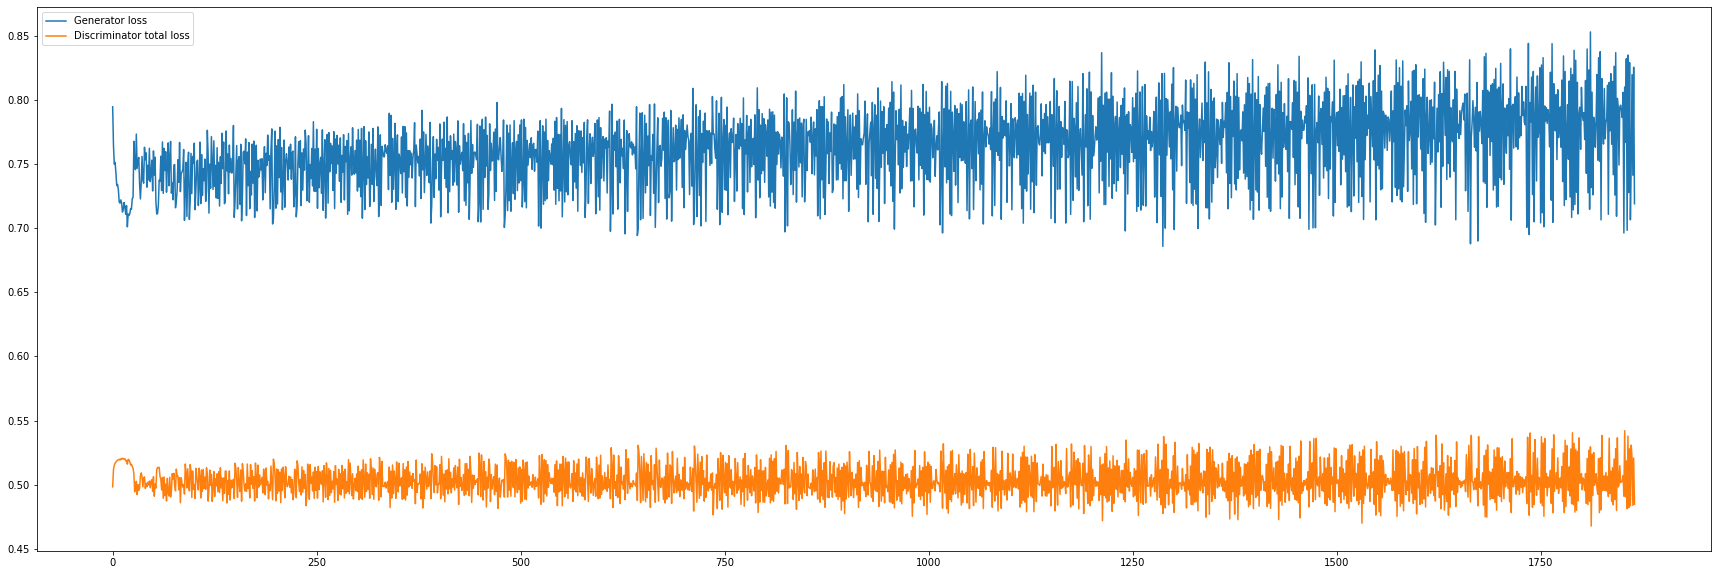

In [10]:
plt.figure(figsize=(30, 10))
plt.plot(range(BATCHES * EPOCHS), g_losses, label='Generator loss')
plt.plot(range(BATCHES * EPOCHS), d_losses, label='Discriminator total loss')
plt.legend(loc='best')
plt.show()

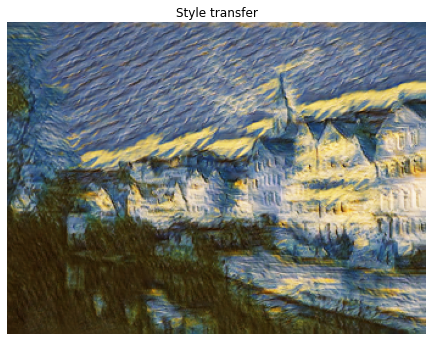

In [11]:
output_image = Image.fromarray(torch.clamp((gen(torchvision.transforms.ToTensor()(content_image).unsqueeze(0).to(device)).cpu().detach().squeeze(0).permute(1,2,0) + 1) / 2 * 255, min=0, max=255).type(torch.uint8).numpy())
plt.figure(figsize=(7.5, 7.5))
plt.imshow(output_image)
plt.title("Style transfer")
plt.axis("off")
plt.show()

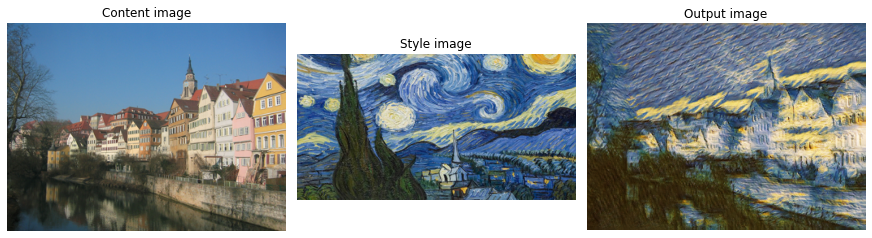

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

ax1.imshow(content_image)
ax1.set_title("Content image")
ax1.axis("off")
ax2.imshow(style_image)
ax2.set_title("Style image")
ax2.axis("off")
ax3.imshow(output_image)
ax3.set_title("Output image")
ax3.axis("off")
plt.show()

### Литература

1. Zheng, Z. & Liu, J. (2020). P²-GAN: Efficient Style Transfer Using Single Style Image. arXiv.
2. Authors' implementation of *P²-GAN: Efficient Style Transfer Using Single Style Image* paper. online at: https://github.com/i-evi/p2gan